In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
covid_19_df = pd.read_csv('covid_19_clean_complete.csv')
covid_19_df['Date'] = pd.to_datetime(covid_19_df['Date'], format='%d/%m/%Y')
covid_19_df['Country/Region'] = covid_19_df['Country/Region'].replace('Mainland China', 'China')
covid_19_df.tail(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
17458,NaN,Eritrea,15.1794,39.7823,2020-03-21,1,0,0
17459,NaN,Uganda,1.0000,32.0000,2020-03-21,1,0,0


In [4]:
cases = ['Confirmed', 'Active', 'Recovered', 'Deaths']
growth = ['Confirmed_growth', 'Deaths_growth', 'Recovered_growth', 'Confirmed_growth_mean']
covid_19_df['Active'] = covid_19_df['Confirmed'] - covid_19_df['Deaths'] - covid_19_df['Recovered']
# covid_19_df = covid_19_df.sort_values(by=['Date'], ascending=True)
covid_19_df.head(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,NaN,Thailand,15.0,101.0,2020-01-22,2,0,0,2
1,NaN,Japan,36.0,138.0,2020-01-22,2,0,0,2


### Finding Countries with most confirmed cases

In [5]:
last_covid_df = covid_19_df[covid_19_df['Date'] == covid_19_df['Date'].max()].reset_index(drop=True)
last_covid_df = last_covid_df.drop(columns=['Lat', 'Long'])
top_50 = last_covid_df.groupby('Country/Region').sum().sort_values(by='Confirmed', ascending=False).head(50)
top_50.head(2)

,Confirmed,Deaths,Recovered,Active
Country/Region,,,,
China,81305,3259,71857,6189
Italy,53578,4825,6072,42681


In [6]:
def prepare_data(df, country, *lower_bound):
    df = df[df['Country/Region'] == country]
    if (country == 'China') | (country == 'US') | (country == 'Australia') | (country == 'Canada'):
        df = df.groupby('Date').sum().reset_index()
    elif df[df['Province/State'] == country].notna().any().any():
        df = df[df['Province/State'] == country]
    df = df.sort_values(by='Date').reset_index(drop=True)

    if lower_bound:
        df = df[df.Confirmed > lower_bound].reset_index(drop=True)
#     df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%d/%m/%Y')
    date_range = df['Date'].sort_values().drop_duplicates().reset_index(drop=True)
    date_range = date_range.dt.strftime('%d-%m')
    return df, date_range

In [7]:
def show_increment(df, label, date_range):
    my_xticks = range(0, len(date_range), 5)
    my_xticks_labels = list(date_range)[0:len(date_range):5]
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax1 = sns.lineplot(data=df[cases], ax=ax)
    ax1.set_xticks(my_xticks)
    ax1.set_xticklabels(my_xticks_labels)
    ax1.set_xlabel(label)
    plt.show()
    
    print('\nDaily growth for each types of cases\n')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(23, 5))
    ax1 = sns.barplot(x=date_range.index, y='Confirmed_growth', data=df, ax=ax1, palette=cm.Blues(df.Confirmed_growth/max(df.Confirmed_growth*1.5)+0.3))
    ax1.set_xticks(my_xticks)
    ax1.set_xticklabels(my_xticks_labels)
    ax1.set_xlabel('Daily Confirmed growth')
    ax1.set_ylabel('Cases')
    
    ax2 = sns.barplot(x=date_range.index, y='Deaths_growth', data=df, ax=ax2, palette=cm.autumn_r(df.Deaths_growth/max(df.Deaths_growth*1.5)+0.3))
    ax2.set_xticks(my_xticks)
    ax2.set_xticklabels(my_xticks_labels)
    ax2.set_xlabel('Daily Deaths growth')
    ax2.set_ylabel('Cases')
    
    ax3 = sns.barplot(x=date_range.index, y='Recovered_growth', data=df, ax=ax3, palette=cm.Greens(df.Recovered_growth/max(df.Recovered_growth)+0.3))
    ax3.set_xticks(my_xticks)
    ax3.set_xticklabels(my_xticks_labels)
    ax3.set_xlabel('Daily Recovered growth')
    ax3.set_ylabel('Cases')
    
    plt.show()

In [8]:
def add_data(covid_19_df):
    covid_19_df['Confirmed_growth'] = covid_19_df['Confirmed'] - covid_19_df['Confirmed'].shift()
    covid_19_df['Confirmed_growth'][0] = covid_19_df['Confirmed'][0]
    covid_19_df = covid_19_df.fillna(0)

    covid_19_df['Deaths_growth'] = covid_19_df['Deaths'] - covid_19_df['Deaths'].shift()
    covid_19_df['Deaths_growth'][0] = covid_19_df['Deaths'][0]
    covid_19_df = covid_19_df.fillna(0)

    covid_19_df['Recovered_growth'] = covid_19_df['Recovered'] - covid_19_df['Recovered'].shift()
    covid_19_df['Recovered_growth'][0] = covid_19_df['Recovered'][0]
    covid_19_df = covid_19_df.fillna(0)
    return covid_19_df

### Plots for 50 countries with most confirmed cases with start data: 50 confirmed cases

The line plot presents all data in the following days starting from the moment when there were more than 50 confirmed cases.<br>
The bar plots show the daily increase in each category. There are some days with negative values caused by changes in the data tables in the source data - maybe some of the cases were wrongly classified as recovered and therefore were removed. 

1 . China
Confirmed: 81305 
Active: 6189 
Recovered: 71857 
Deaths: 3259


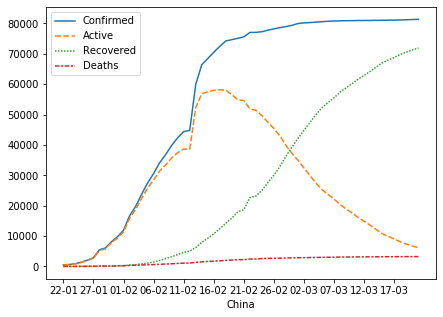


Daily growth for each types of cases



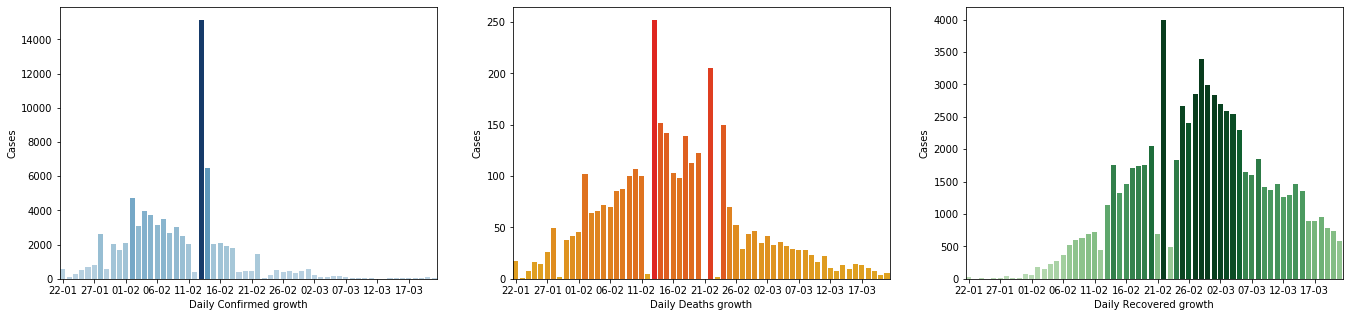

2 . Italy
Confirmed: 53578 
Active: 42681 
Recovered: 6072 
Deaths: 4825


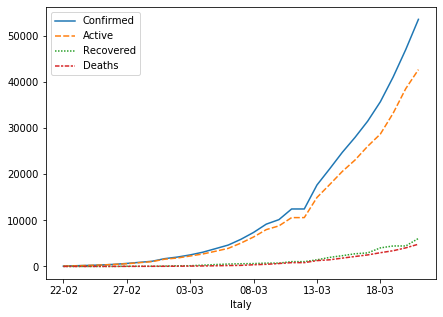


Daily growth for each types of cases



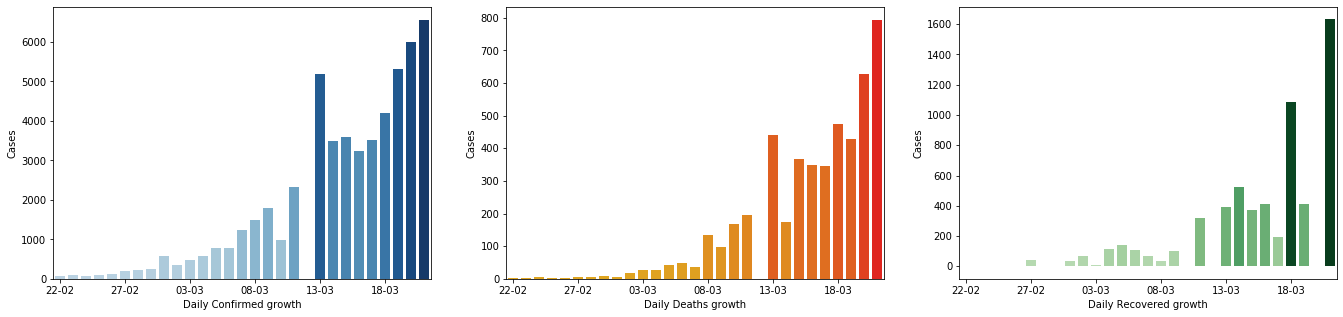

3 . US
Confirmed: 25489 
Active: 25182 
Recovered: 0 
Deaths: 307


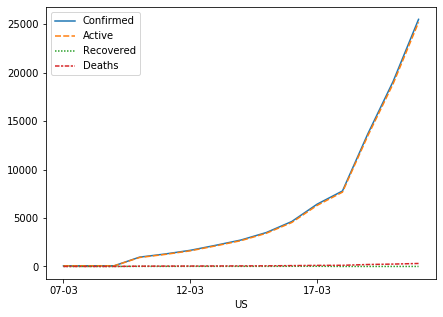


Daily growth for each types of cases



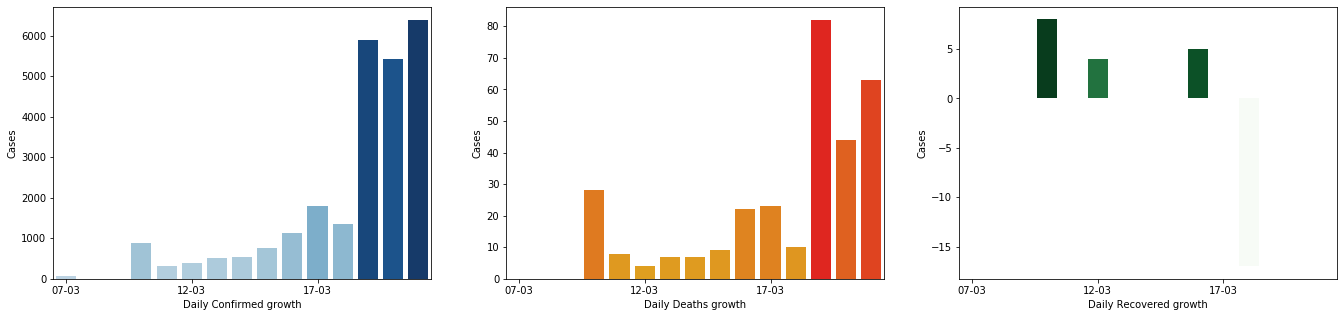

4 . Spain
Confirmed: 25374 
Active: 21874 
Recovered: 2125 
Deaths: 1375


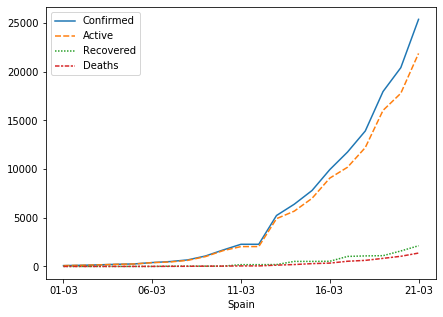


Daily growth for each types of cases



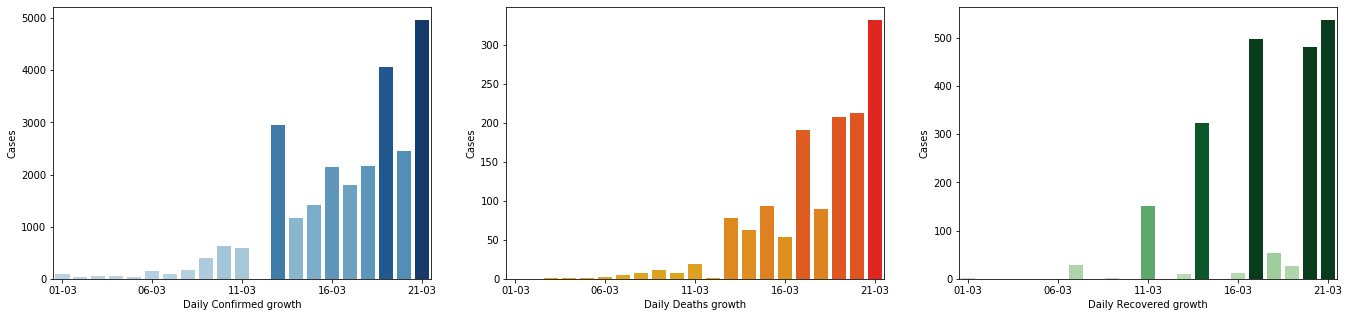

5 . Germany
Confirmed: 22213 
Active: 21896 
Recovered: 233 
Deaths: 84


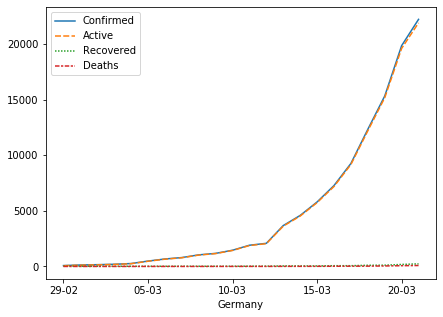


Daily growth for each types of cases



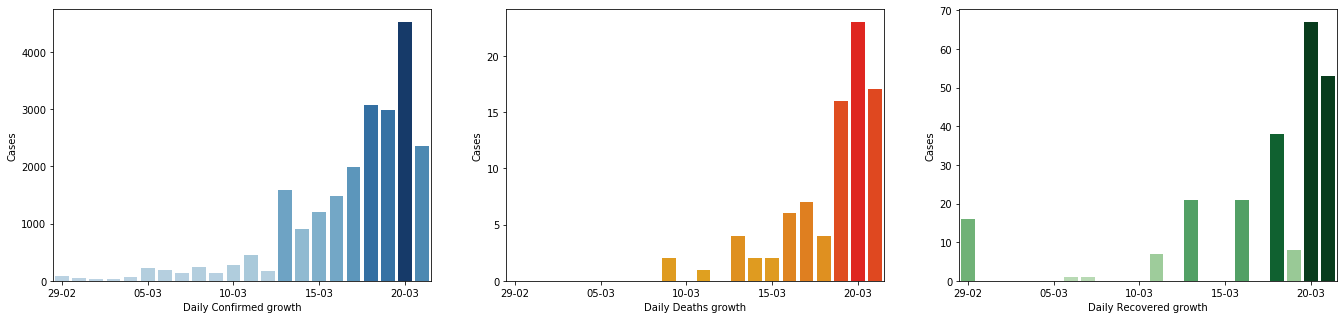

6 . Iran
Confirmed: 20610 
Active: 11419 
Recovered: 7635 
Deaths: 1556


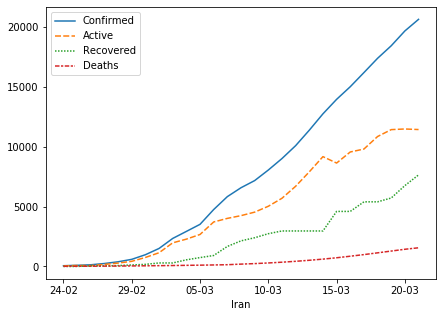


Daily growth for each types of cases



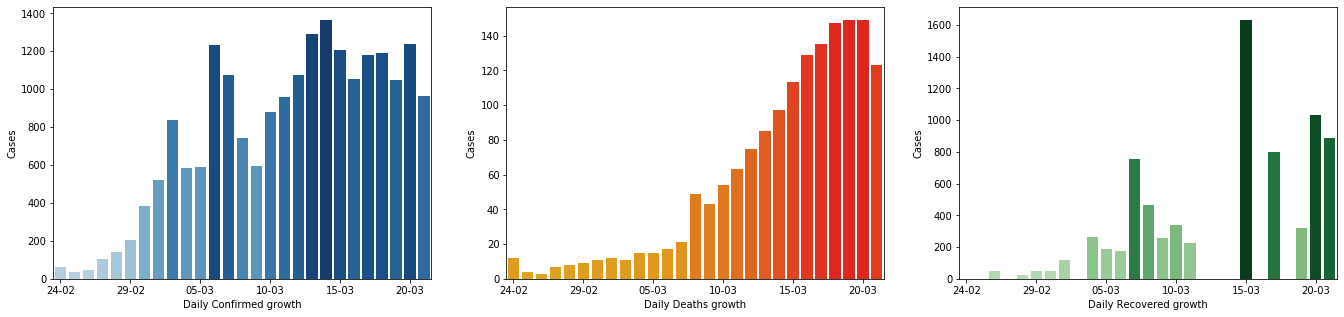

7 . France
Confirmed: 14431 
Active: 13857 
Recovered: 12 
Deaths: 562


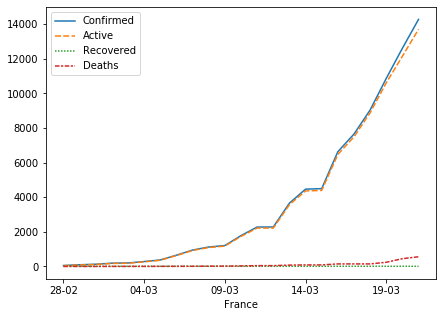


Daily growth for each types of cases



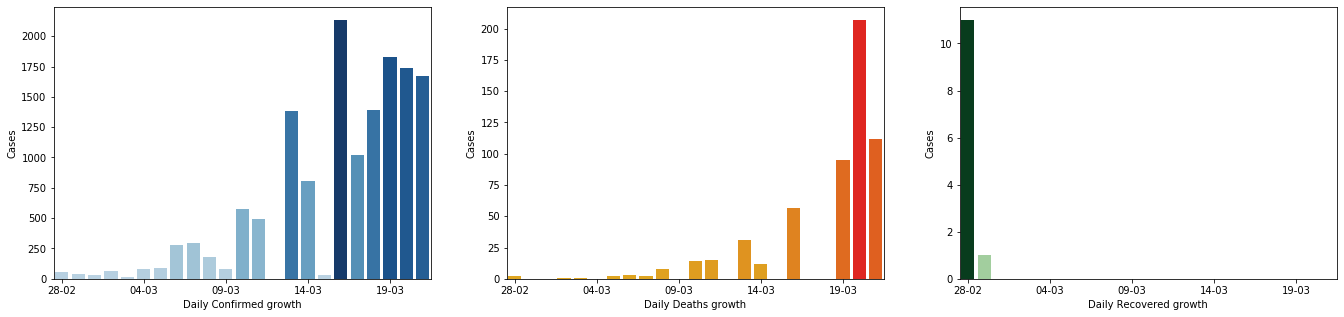

8 . Korea, South
Confirmed: 8799 
Active: 7157 
Recovered: 1540 
Deaths: 102


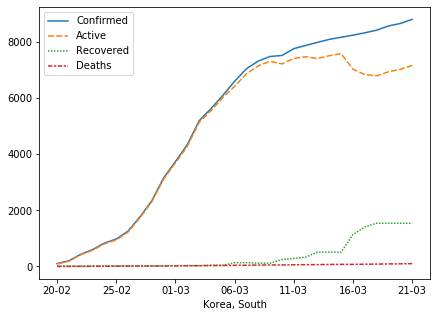


Daily growth for each types of cases



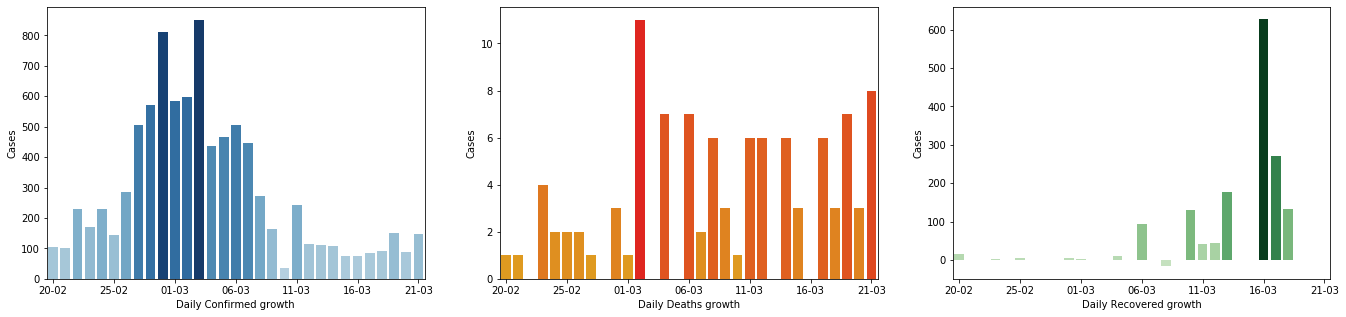

9 . Switzerland
Confirmed: 6575 
Active: 6485 
Recovered: 15 
Deaths: 75


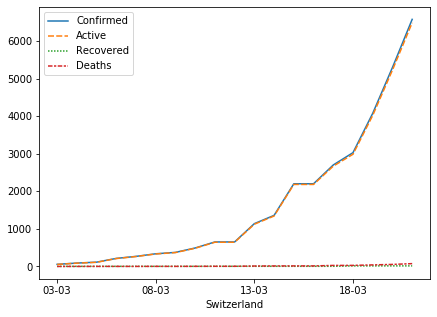


Daily growth for each types of cases



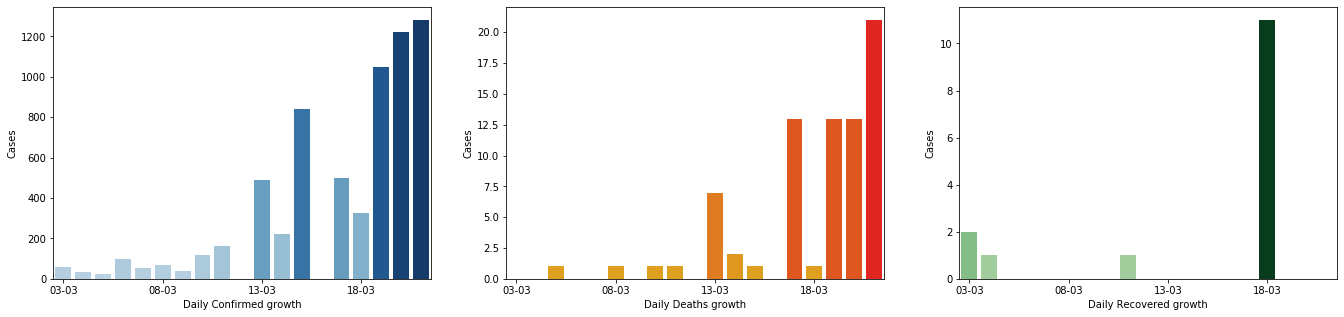

10 . United Kingdom
Confirmed: 5067 
Active: 4766 
Recovered: 67 
Deaths: 234


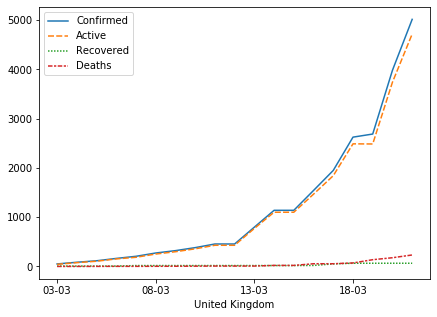


Daily growth for each types of cases



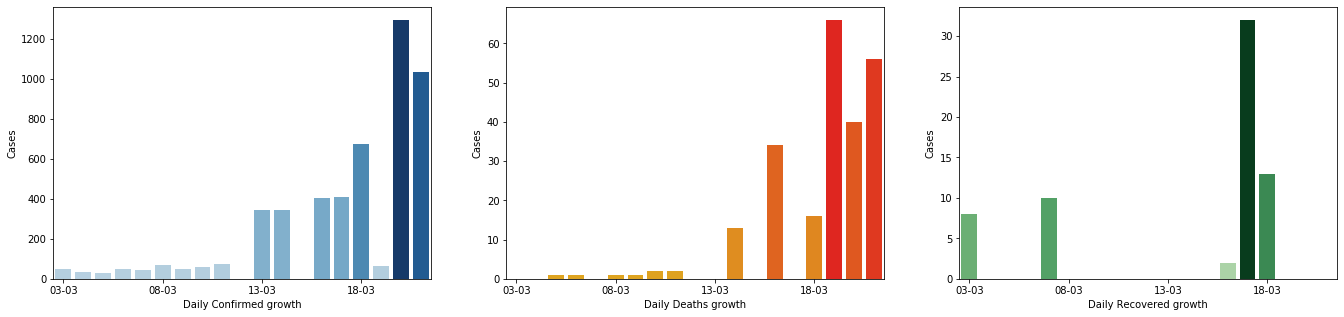

11 . Netherlands
Confirmed: 3640 
Active: 3501 
Recovered: 2 
Deaths: 137


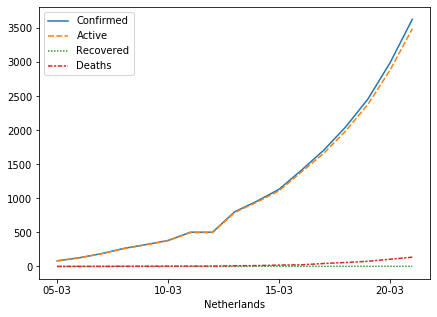


Daily growth for each types of cases



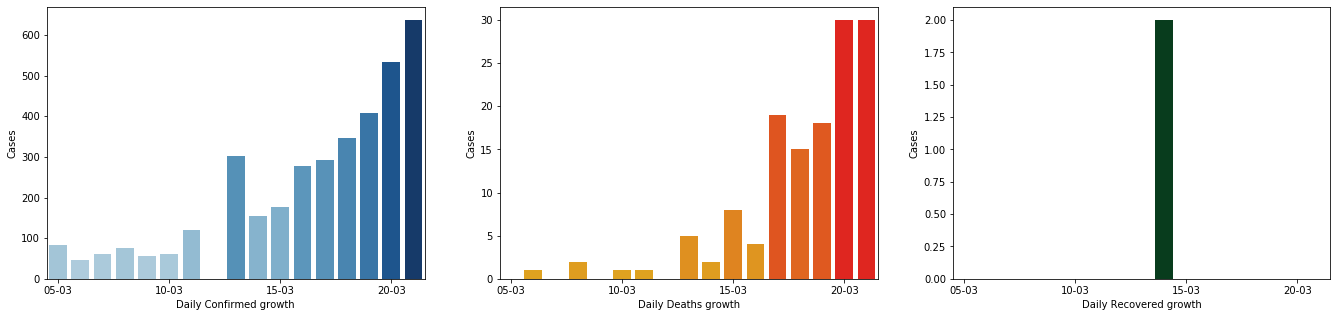

12 . Belgium
Confirmed: 2815 
Active: 2485 
Recovered: 263 
Deaths: 67


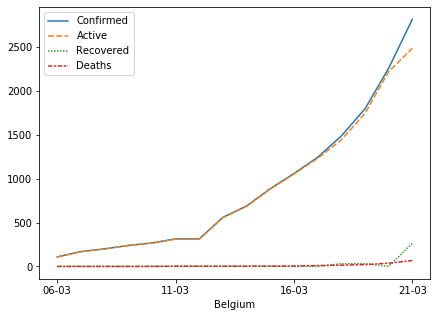


Daily growth for each types of cases



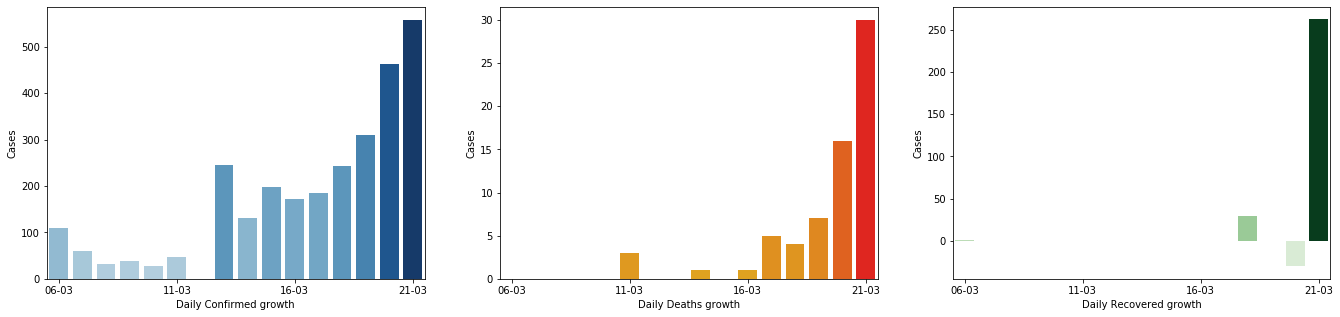

13 . Austria
Confirmed: 2814 
Active: 2797 
Recovered: 9 
Deaths: 8


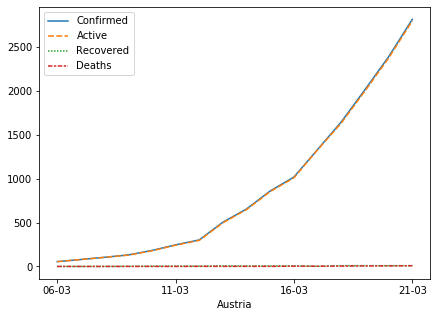


Daily growth for each types of cases



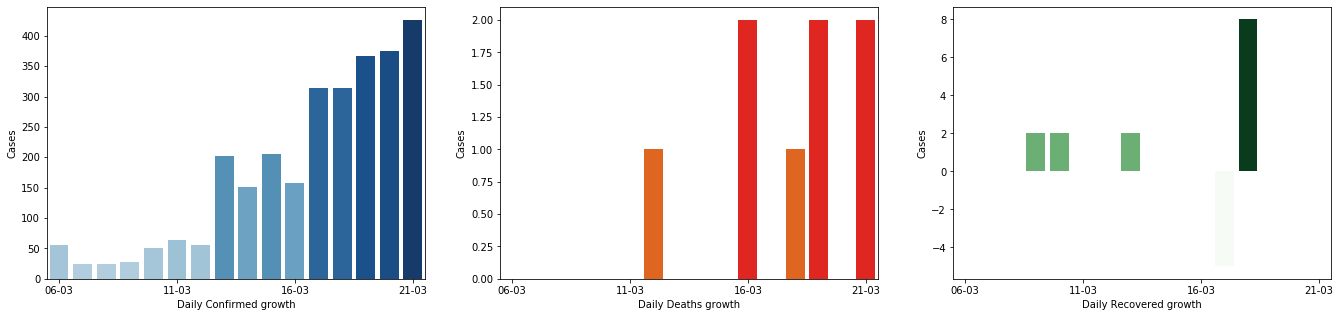

14 . Norway
Confirmed: 2118 
Active: 2110 
Recovered: 1 
Deaths: 7


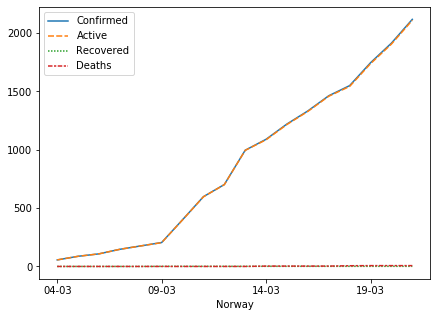


Daily growth for each types of cases



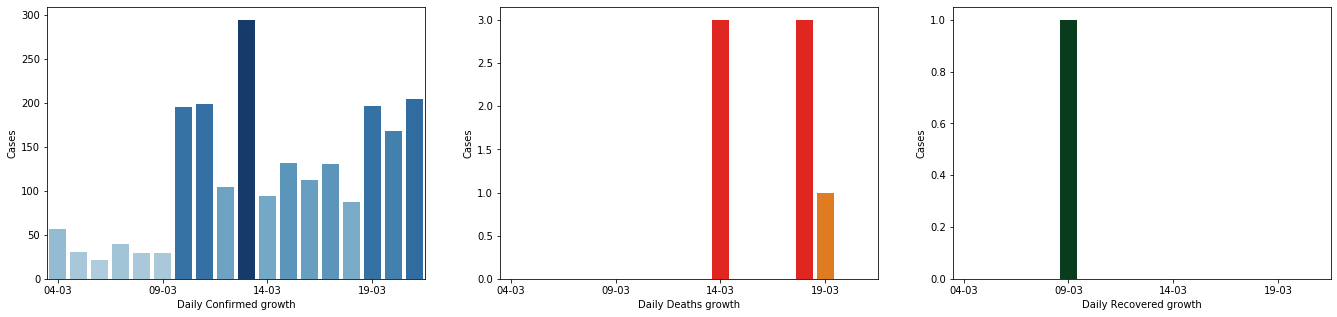

15 . Sweden
Confirmed: 1763 
Active: 1727 
Recovered: 16 
Deaths: 20


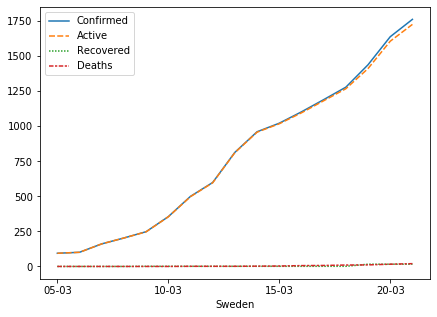


Daily growth for each types of cases



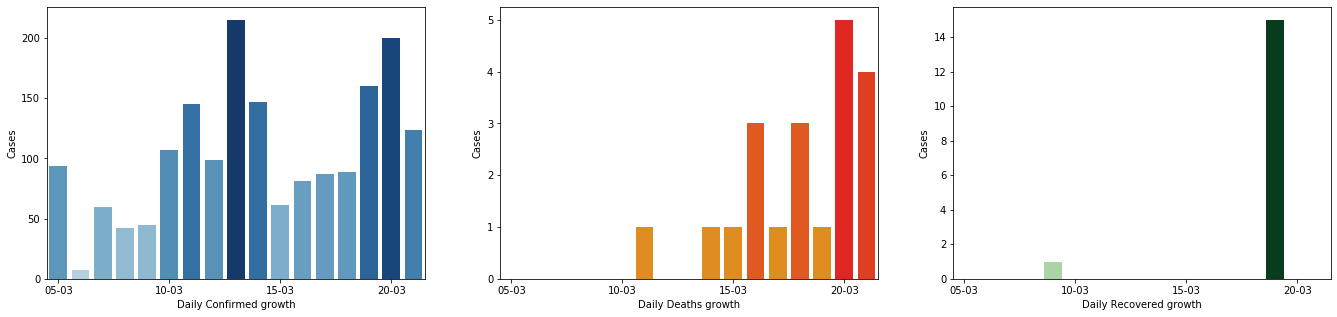

16 . Denmark
Confirmed: 1420 
Active: 1406 
Recovered: 1 
Deaths: 13


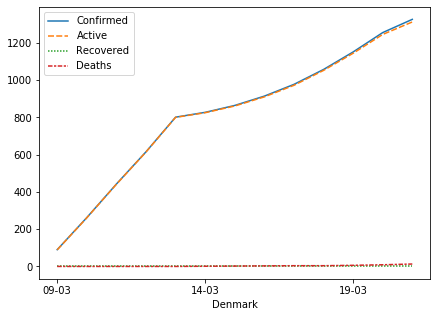


Daily growth for each types of cases



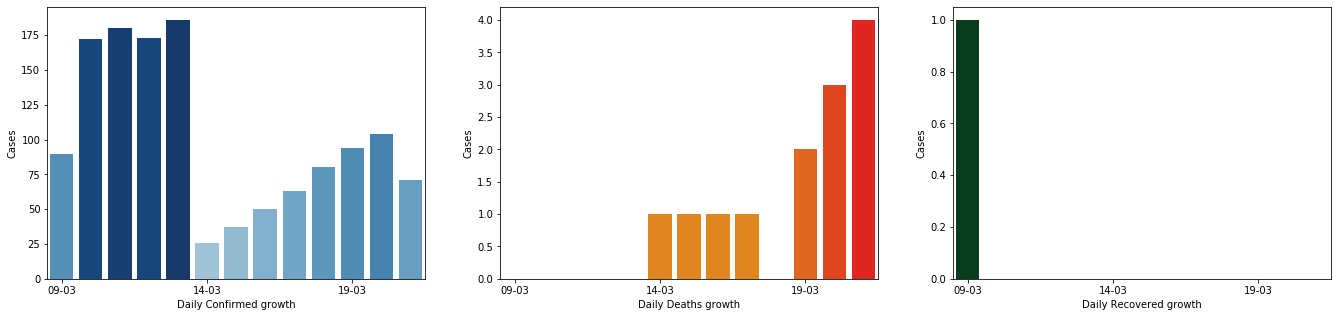

17 . Portugal
Confirmed: 1280 
Active: 1263 
Recovered: 5 
Deaths: 12


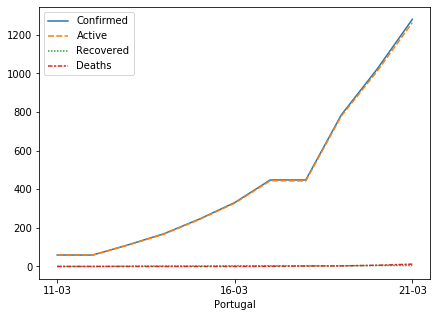


Daily growth for each types of cases



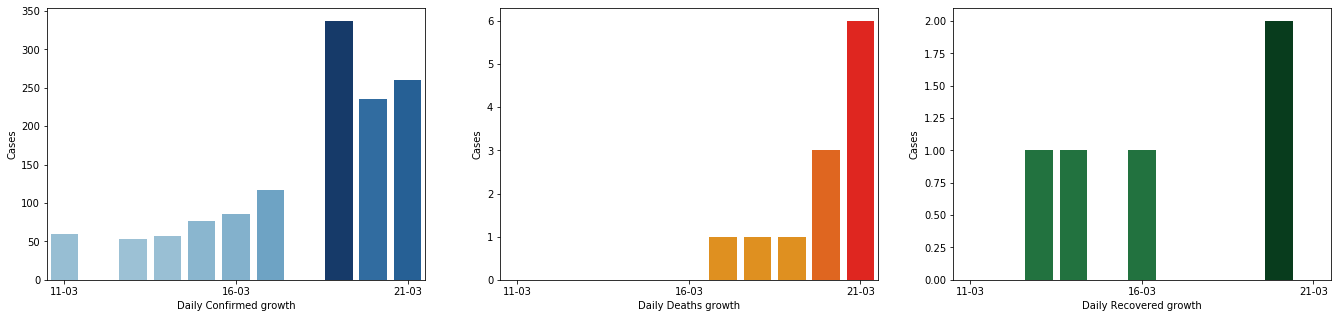

18 . Canada
Confirmed: 1278 
Active: 1249 
Recovered: 10 
Deaths: 19


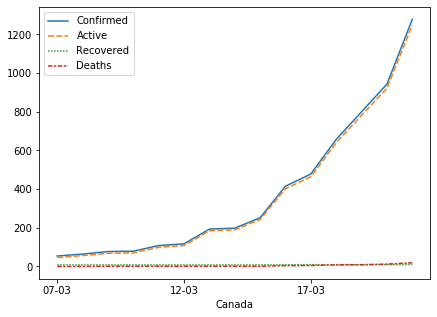


Daily growth for each types of cases



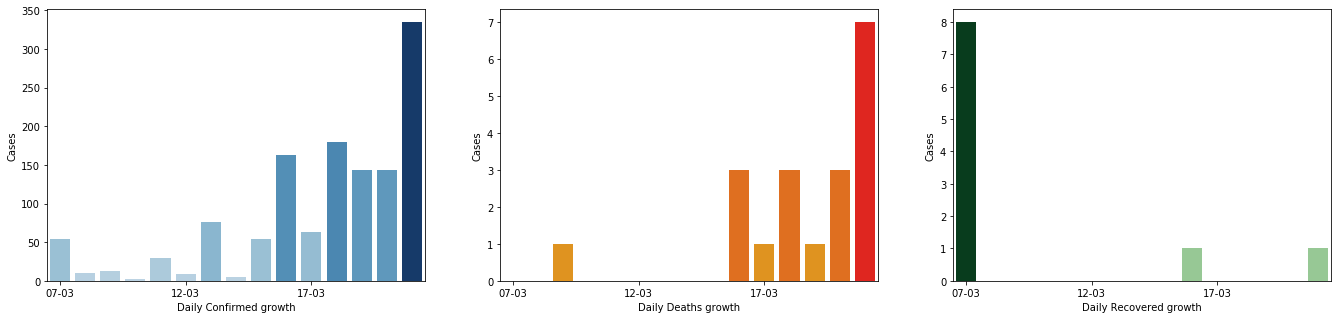

19 . Malaysia
Confirmed: 1183 
Active: 1065 
Recovered: 114 
Deaths: 4


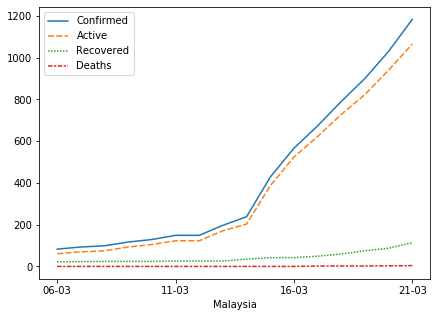


Daily growth for each types of cases



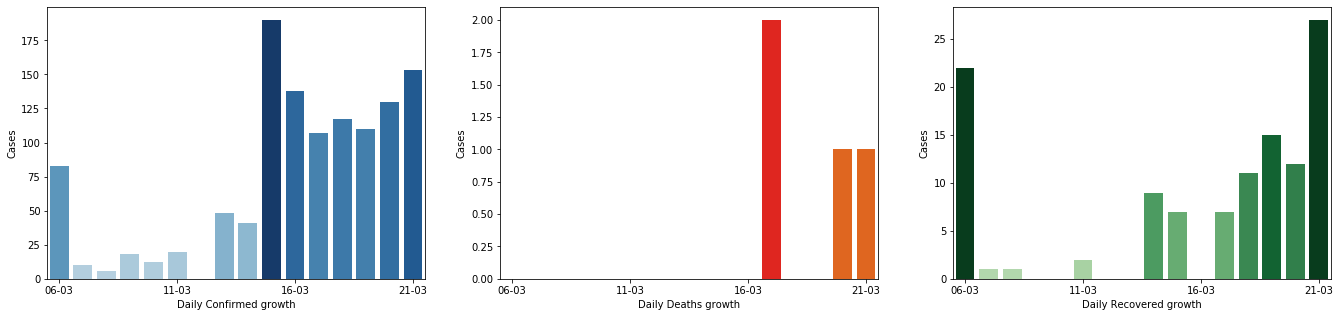

20 . Australia
Confirmed: 1071 
Active: 1038 
Recovered: 26 
Deaths: 7


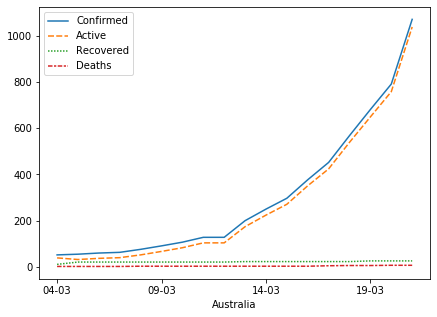


Daily growth for each types of cases



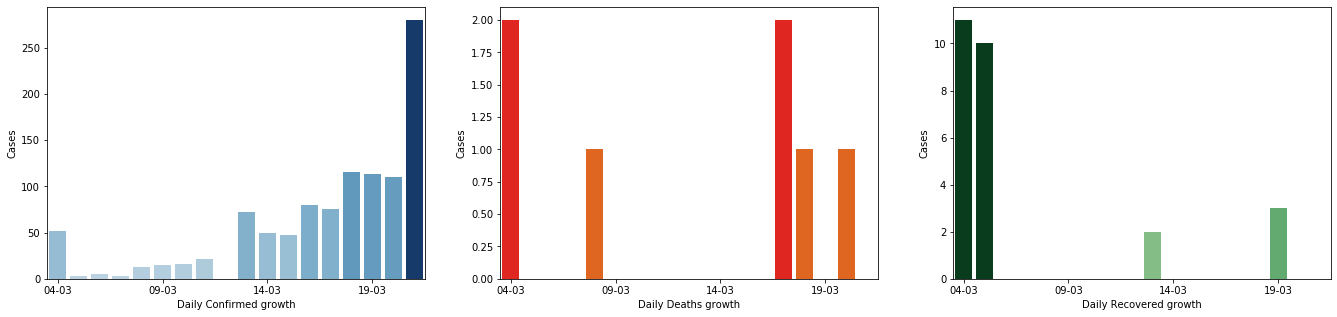

21 . Brazil
Confirmed: 1021 
Active: 1004 
Recovered: 2 
Deaths: 15


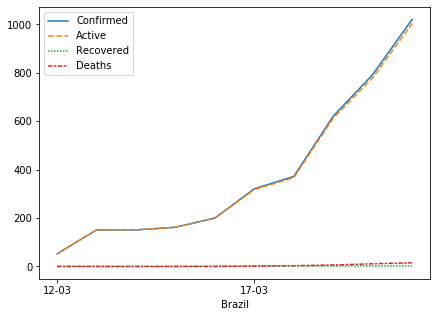


Daily growth for each types of cases



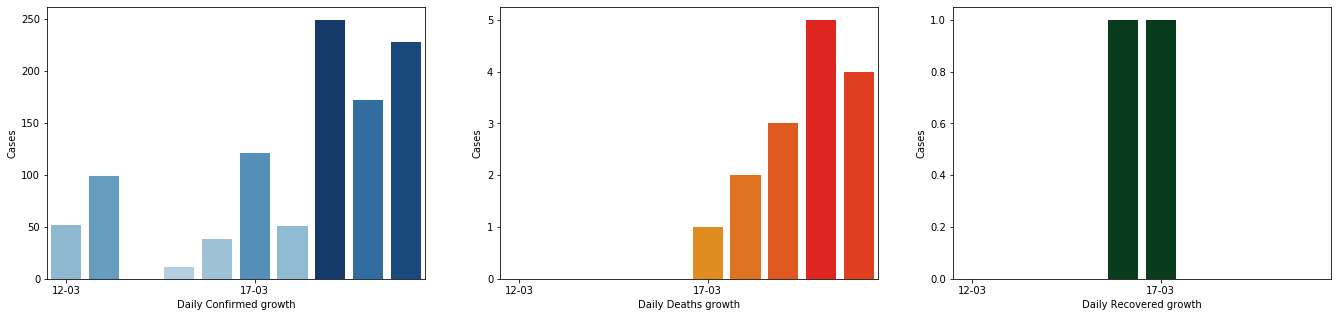

22 . Japan
Confirmed: 1007 
Active: 740 
Recovered: 232 
Deaths: 35


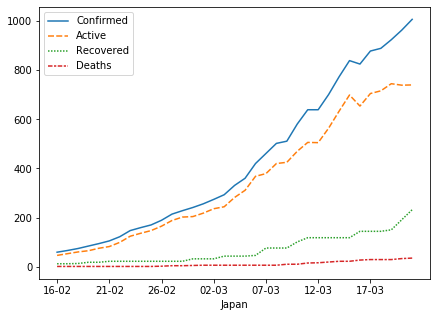


Daily growth for each types of cases



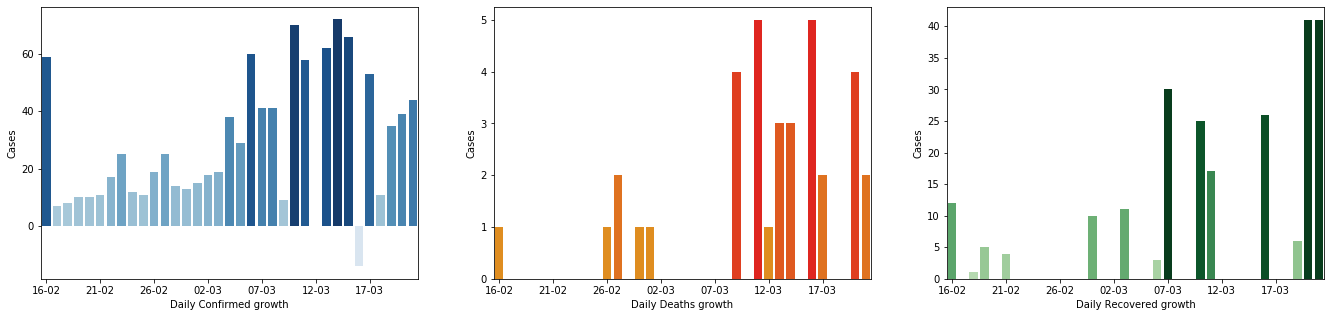

23 . Czechia
Confirmed: 995 
Active: 989 
Recovered: 6 
Deaths: 0


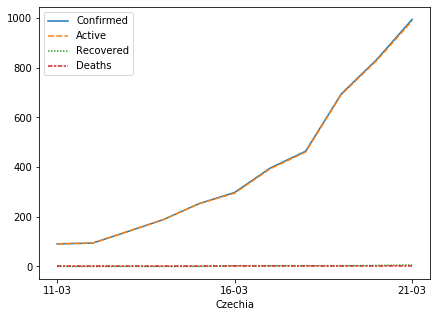


Daily growth for each types of cases



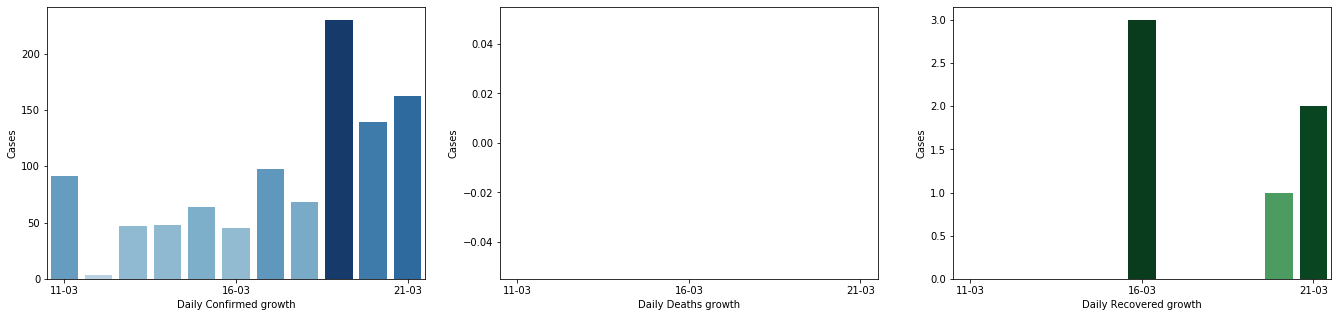

24 . Israel
Confirmed: 883 
Active: 846 
Recovered: 36 
Deaths: 1


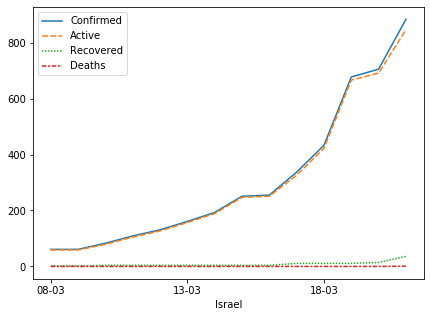


Daily growth for each types of cases



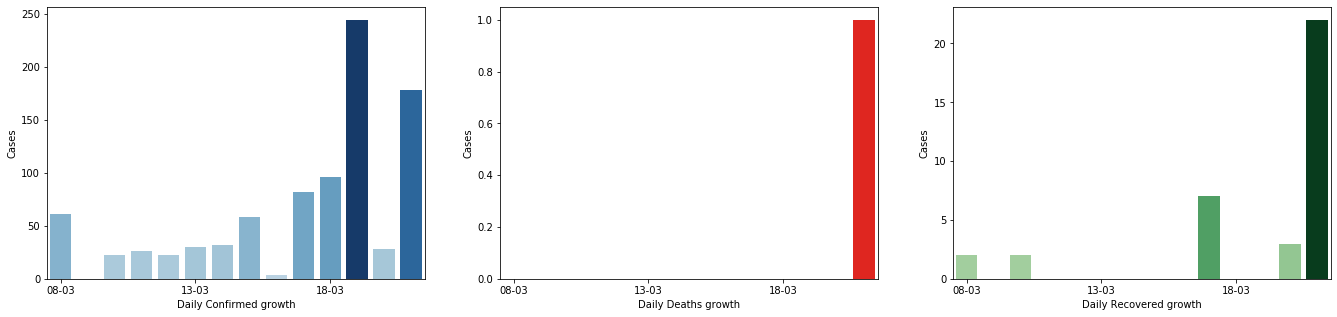

25 . Ireland
Confirmed: 785 
Active: 777 
Recovered: 5 
Deaths: 3


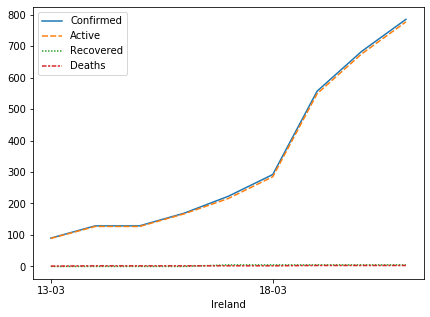


Daily growth for each types of cases



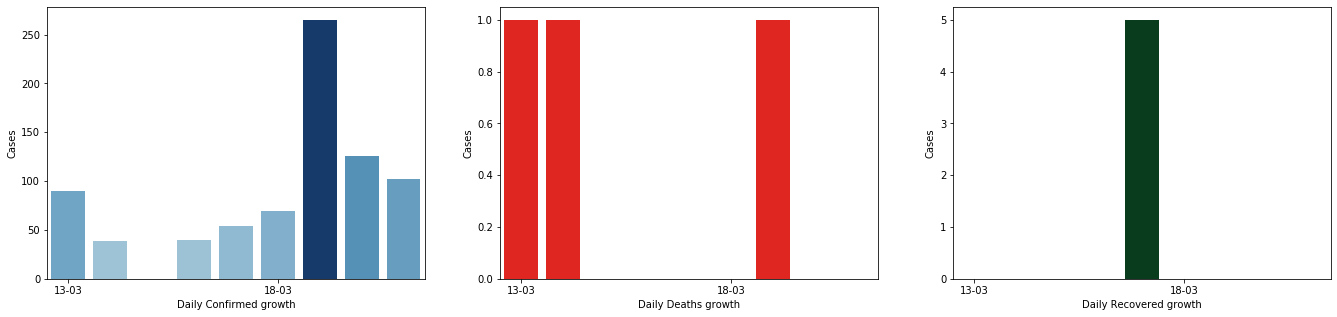

26 . Pakistan
Confirmed: 730 
Active: 714 
Recovered: 13 
Deaths: 3


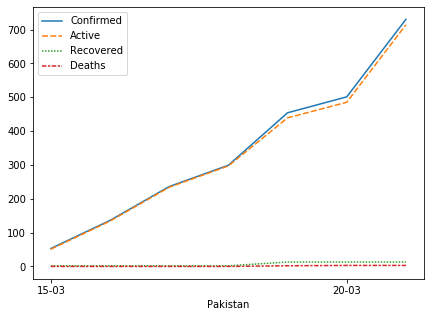


Daily growth for each types of cases



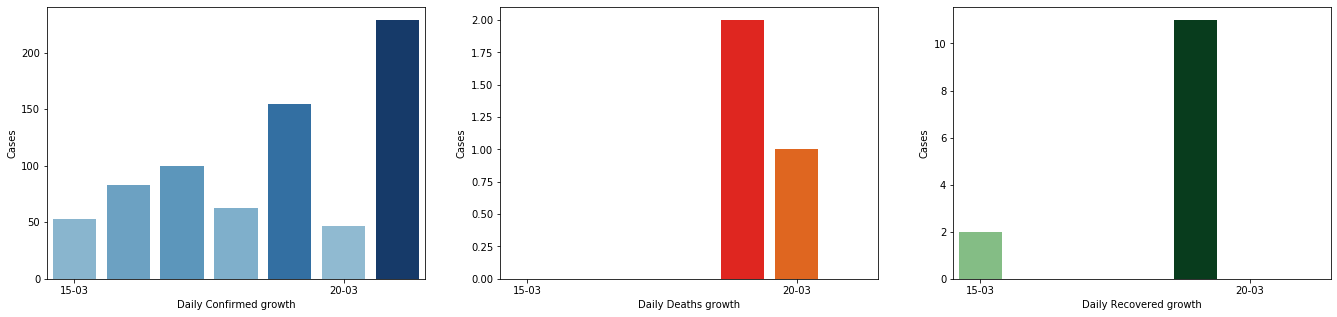

27 . Cruise Ship
Confirmed: 712 
Active: 379 
Recovered: 325 
Deaths: 8


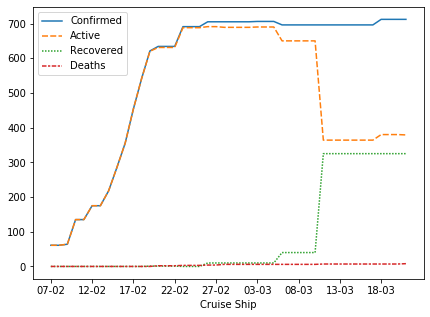


Daily growth for each types of cases



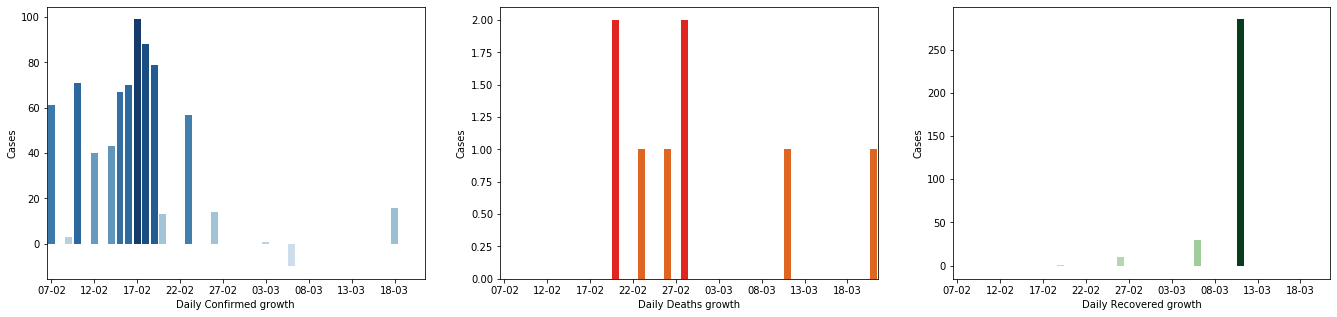

28 . Turkey
Confirmed: 670 
Active: 661 
Recovered: 0 
Deaths: 9


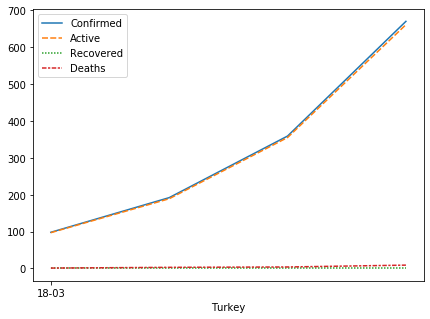


Daily growth for each types of cases



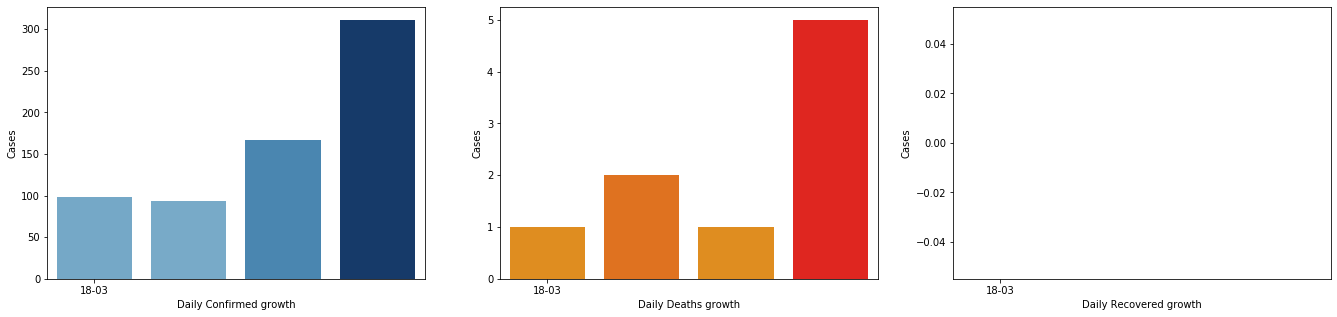

29 . Luxembourg
Confirmed: 670 
Active: 662 
Recovered: 0 
Deaths: 8


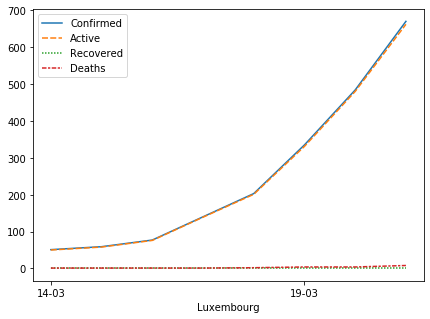


Daily growth for each types of cases



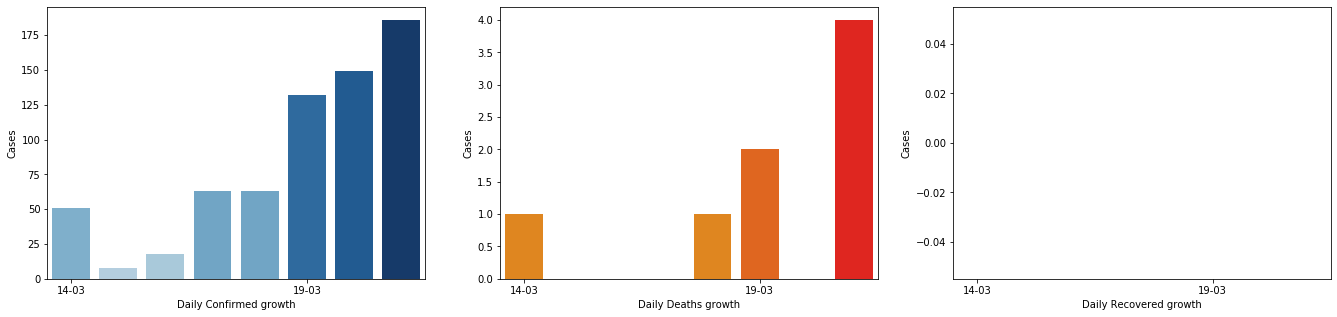

30 . Chile
Confirmed: 537 
Active: 531 
Recovered: 6 
Deaths: 0


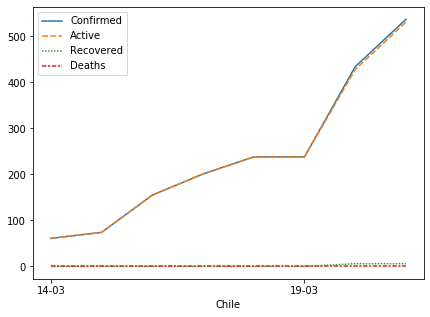


Daily growth for each types of cases



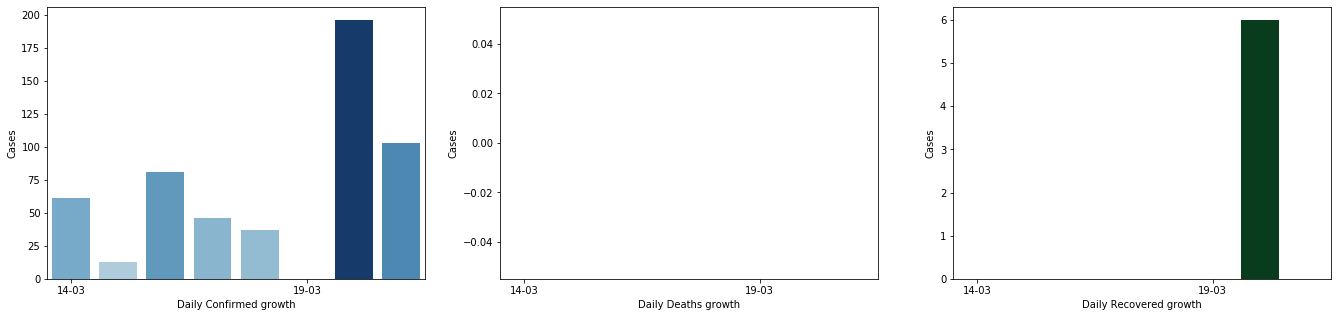

31 . Poland
Confirmed: 536 
Active: 530 
Recovered: 1 
Deaths: 5


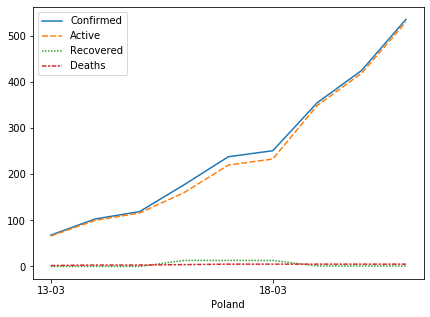


Daily growth for each types of cases



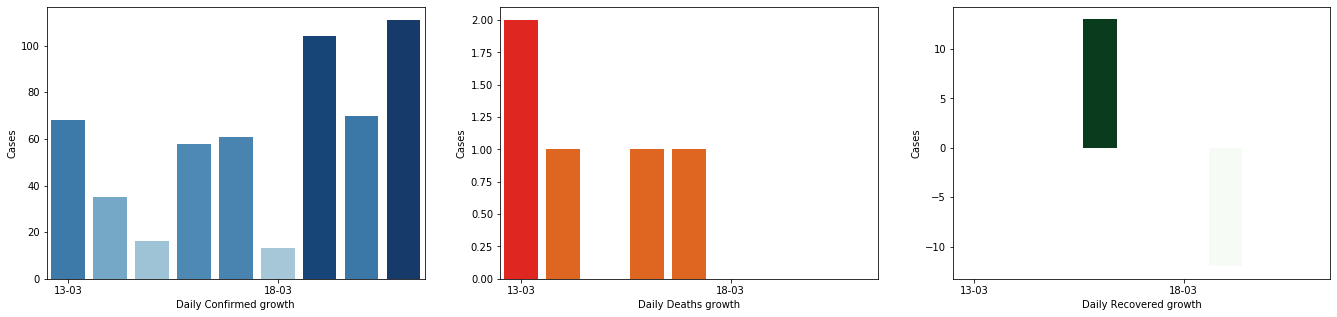

32 . Greece
Confirmed: 530 
Active: 498 
Recovered: 19 
Deaths: 13


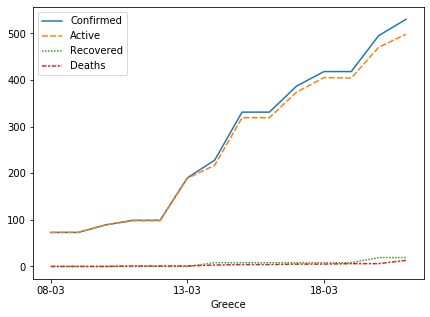


Daily growth for each types of cases



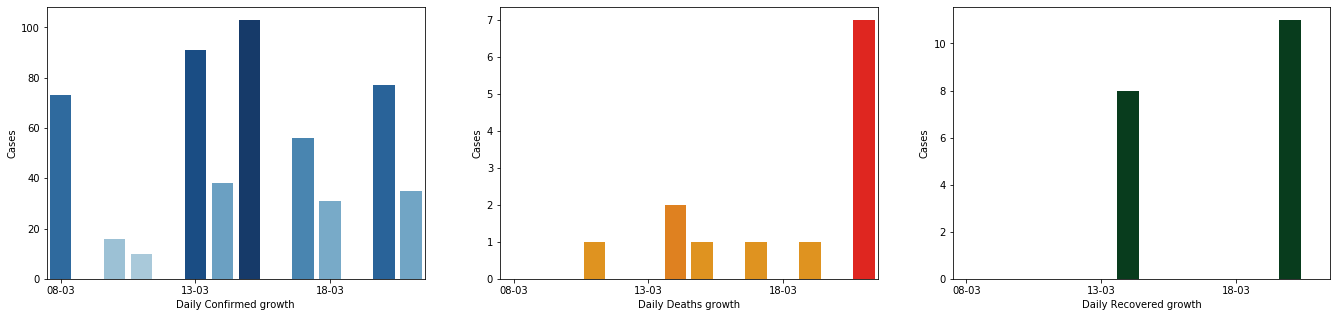

33 . Finland
Confirmed: 523 
Active: 512 
Recovered: 10 
Deaths: 1


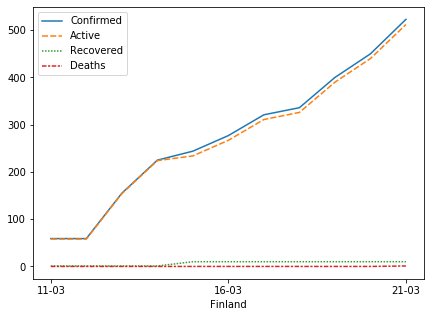


Daily growth for each types of cases



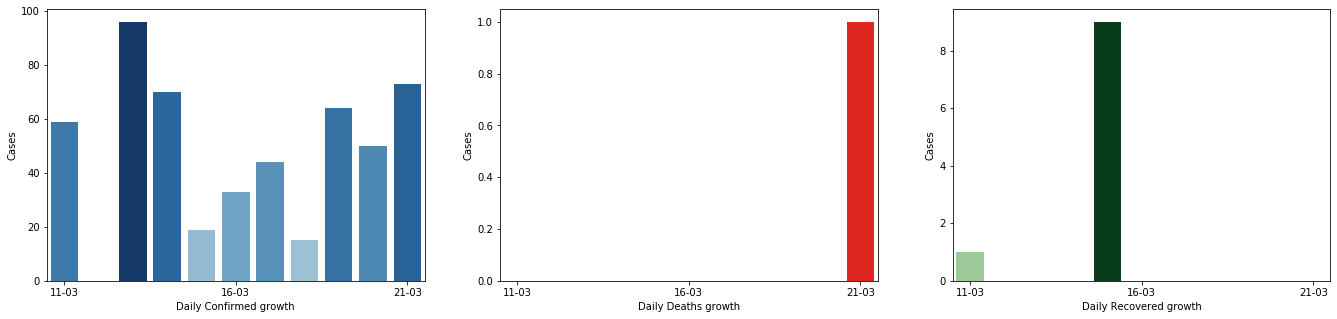

34 . Ecuador
Confirmed: 506 
Active: 496 
Recovered: 3 
Deaths: 7


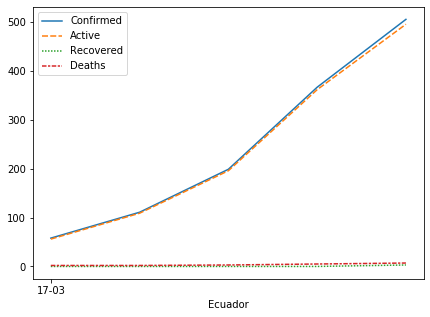


Daily growth for each types of cases



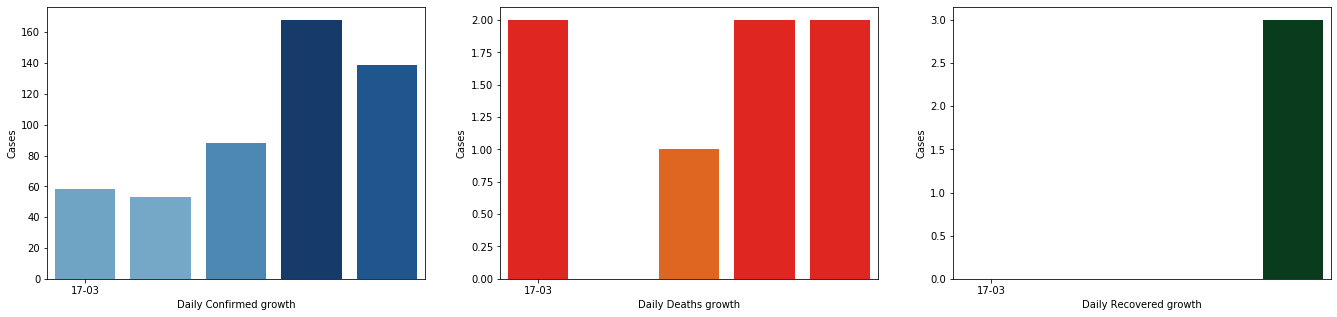

35 . Qatar
Confirmed: 481 
Active: 454 
Recovered: 27 
Deaths: 0


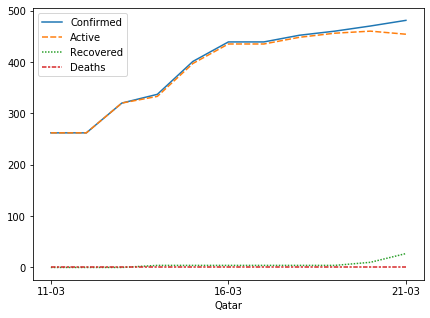


Daily growth for each types of cases



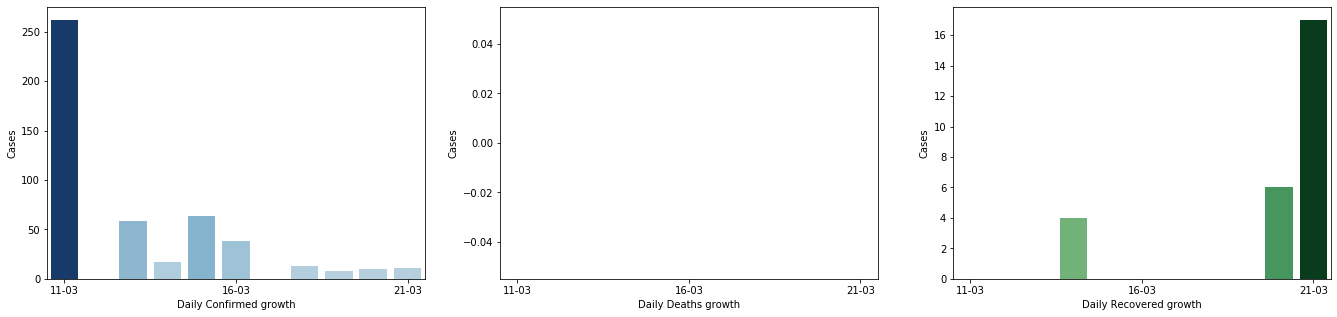

36 . Iceland
Confirmed: 473 
Active: 450 
Recovered: 22 
Deaths: 1


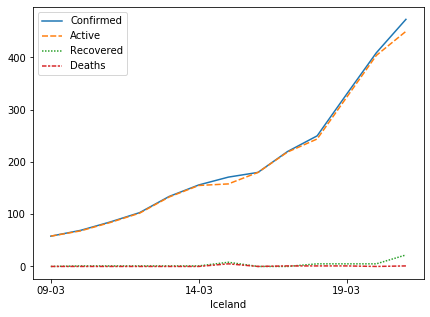


Daily growth for each types of cases



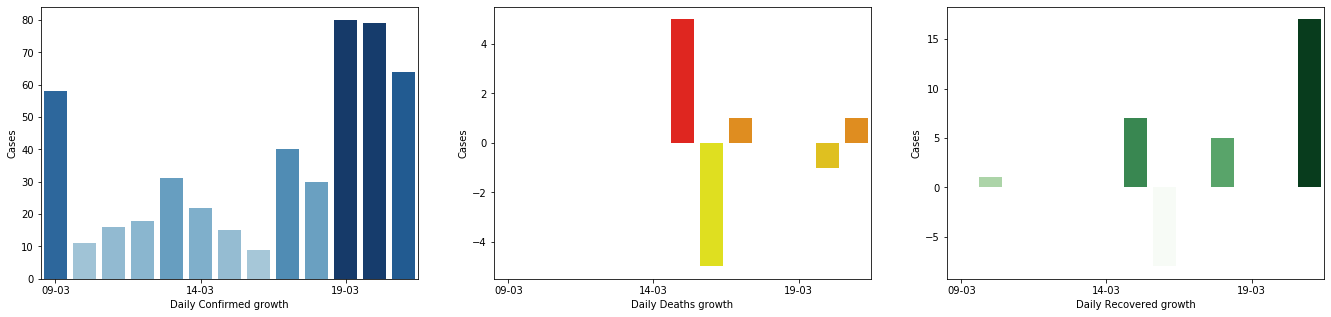

37 . Indonesia
Confirmed: 450 
Active: 397 
Recovered: 15 
Deaths: 38


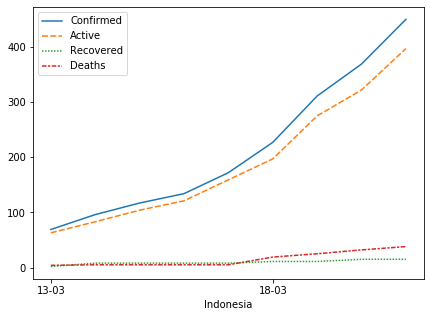


Daily growth for each types of cases



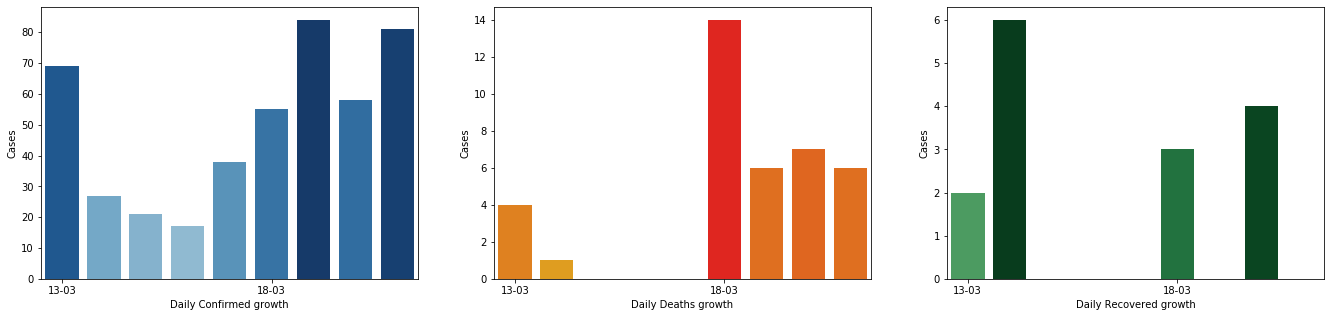

38 . Singapore
Confirmed: 432 
Active: 290 
Recovered: 140 
Deaths: 2


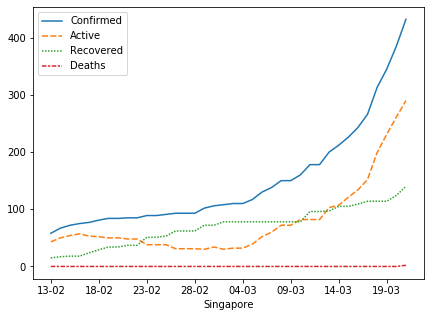


Daily growth for each types of cases



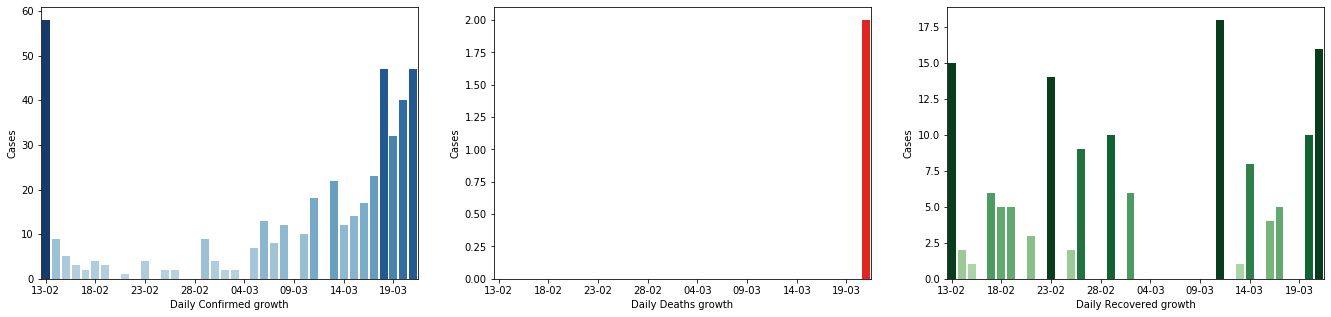

39 . Thailand
Confirmed: 411 
Active: 368 
Recovered: 42 
Deaths: 1


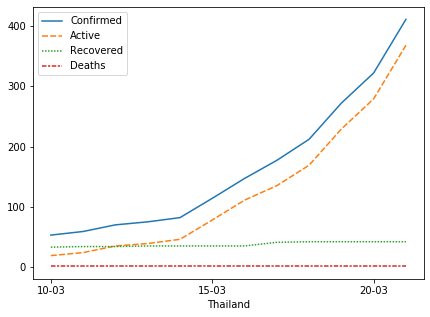


Daily growth for each types of cases



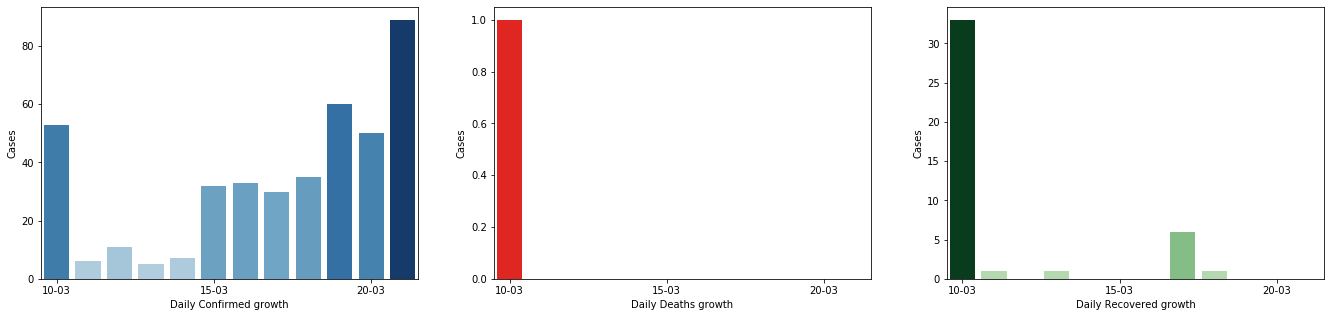

40 . Saudi Arabia
Confirmed: 392 
Active: 376 
Recovered: 16 
Deaths: 0


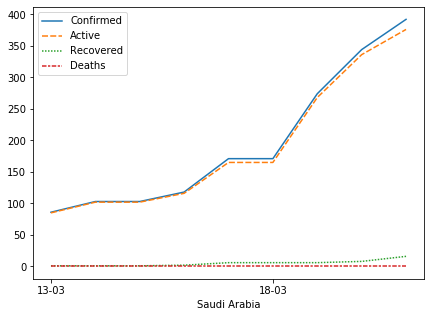


Daily growth for each types of cases



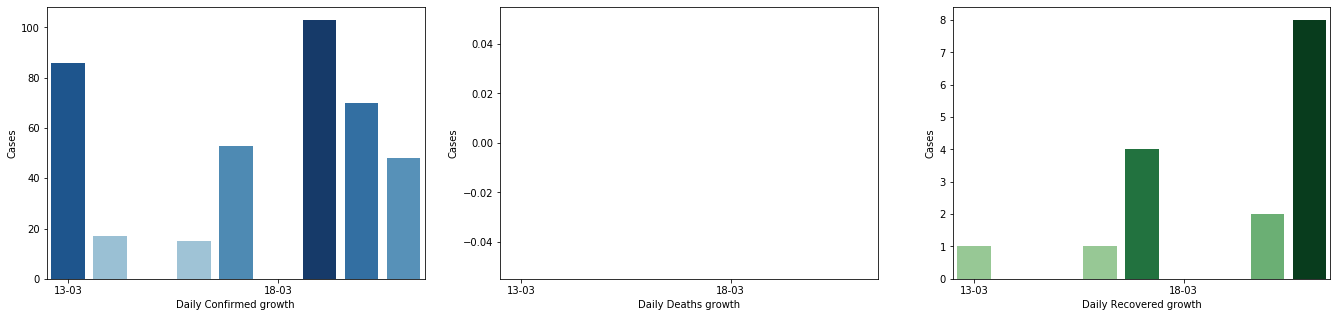

41 . Slovenia
Confirmed: 383 
Active: 382 
Recovered: 0 
Deaths: 1


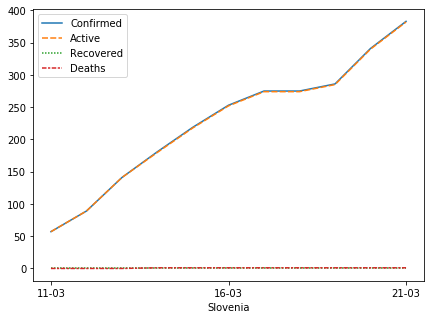


Daily growth for each types of cases



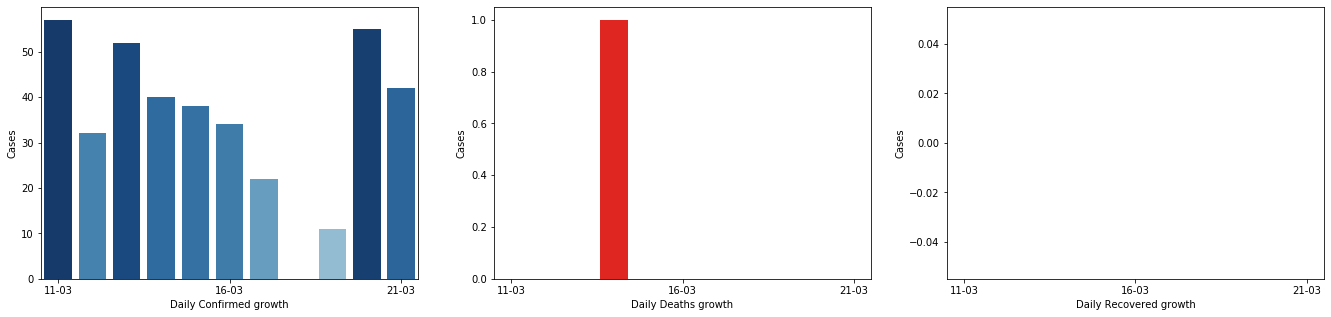

42 . Romania
Confirmed: 367 
Active: 315 
Recovered: 52 
Deaths: 0


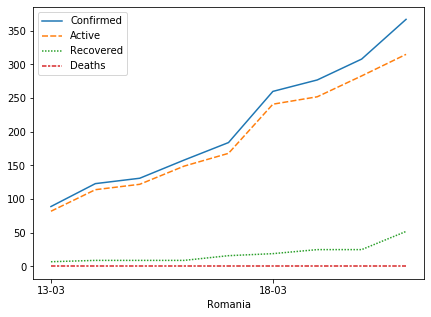


Daily growth for each types of cases



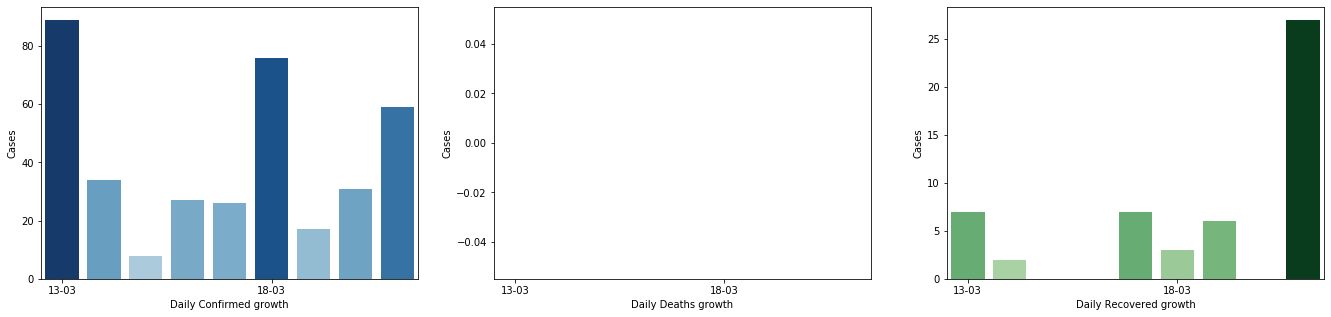

43 . India
Confirmed: 330 
Active: 303 
Recovered: 23 
Deaths: 4


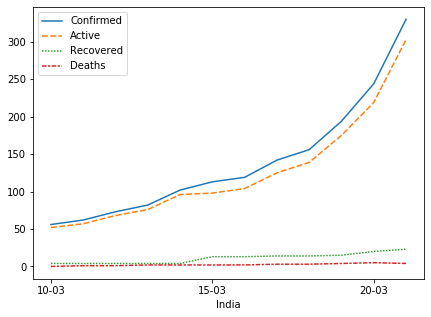


Daily growth for each types of cases



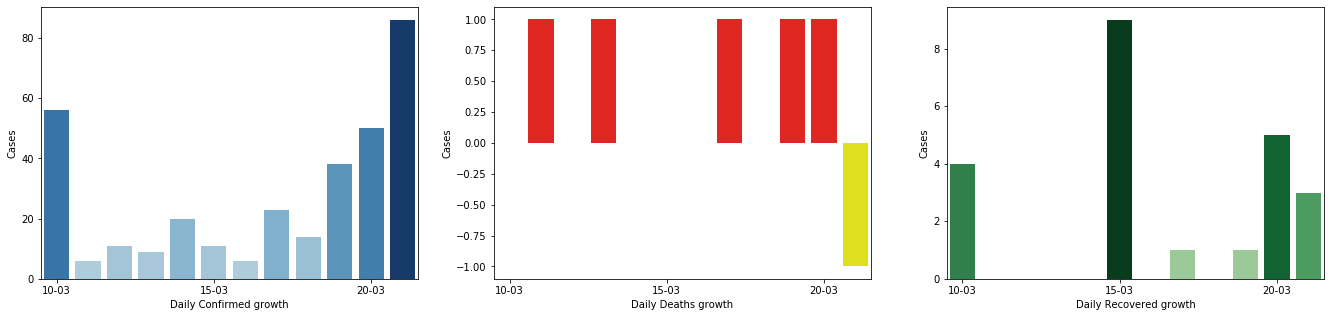

44 . Peru
Confirmed: 318 
Active: 312 
Recovered: 1 
Deaths: 5


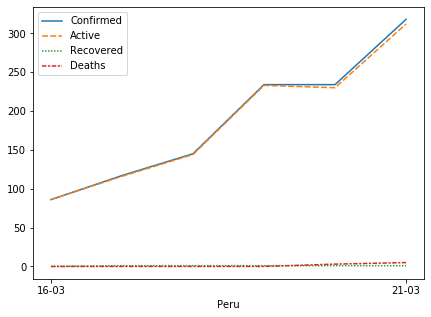


Daily growth for each types of cases



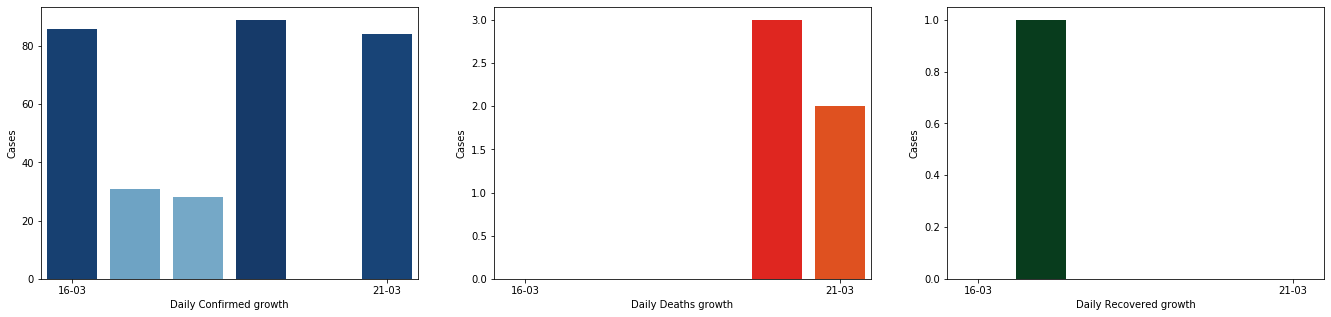

45 . Philippines
Confirmed: 307 
Active: 275 
Recovered: 13 
Deaths: 19


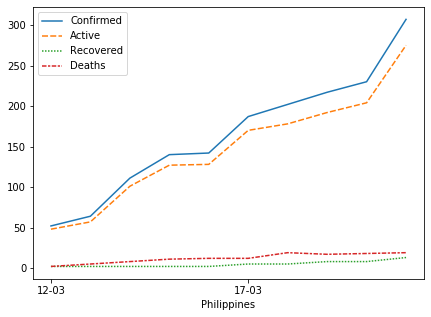


Daily growth for each types of cases



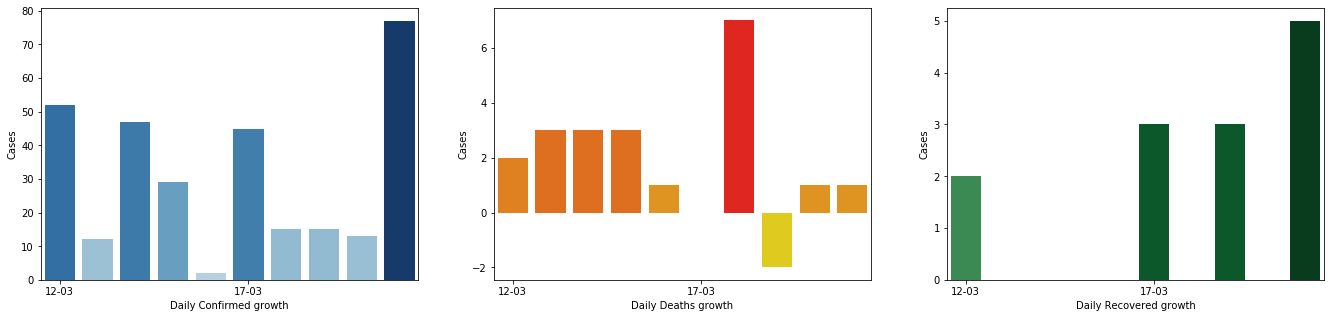

46 . Russia
Confirmed: 306 
Active: 293 
Recovered: 12 
Deaths: 1


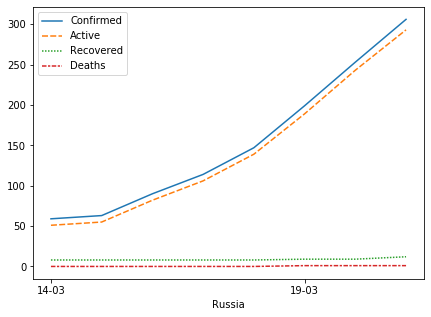


Daily growth for each types of cases



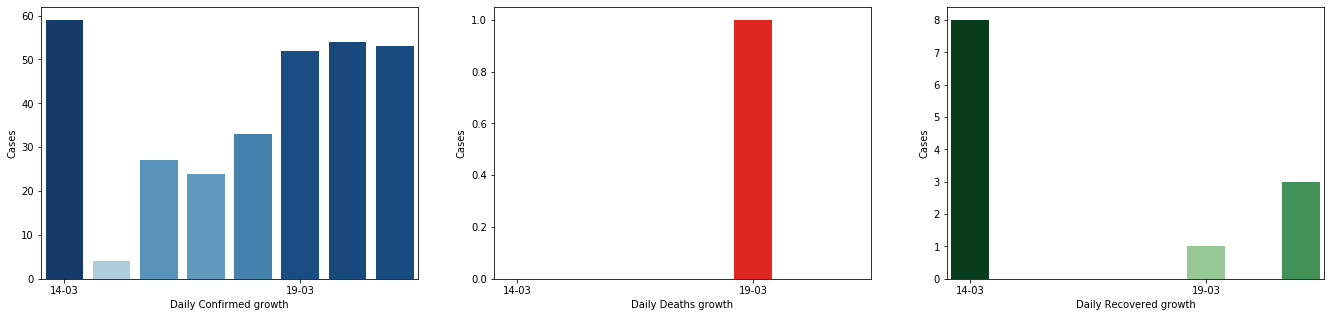

47 . Estonia
Confirmed: 306 
Active: 305 
Recovered: 1 
Deaths: 0


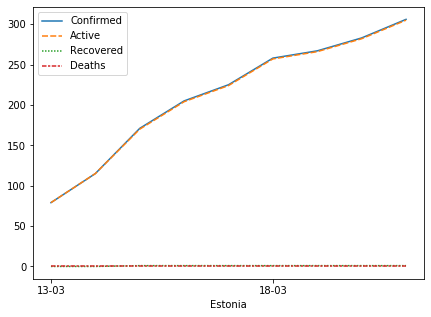


Daily growth for each types of cases



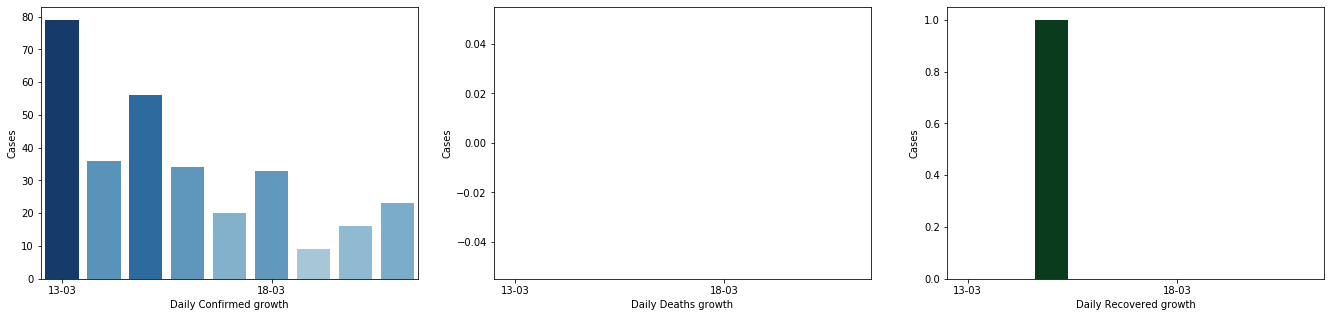

48 . Bahrain
Confirmed: 305 
Active: 179 
Recovered: 125 
Deaths: 1


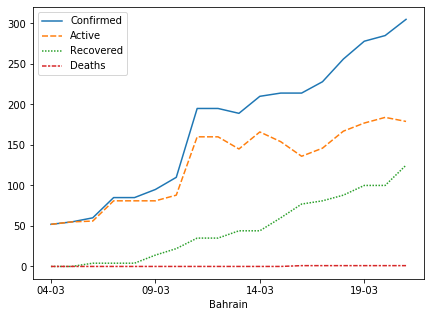


Daily growth for each types of cases



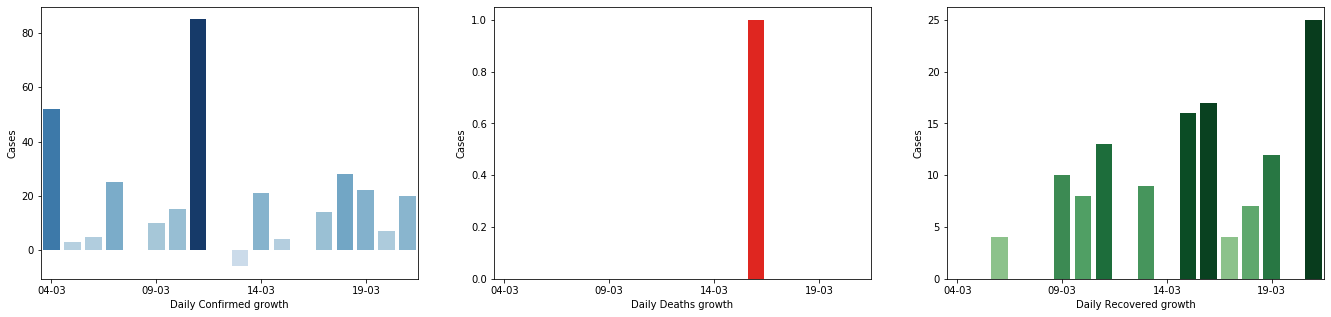

49 . Egypt
Confirmed: 294 
Active: 243 
Recovered: 41 
Deaths: 10


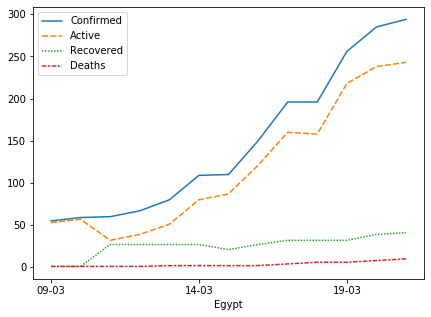


Daily growth for each types of cases



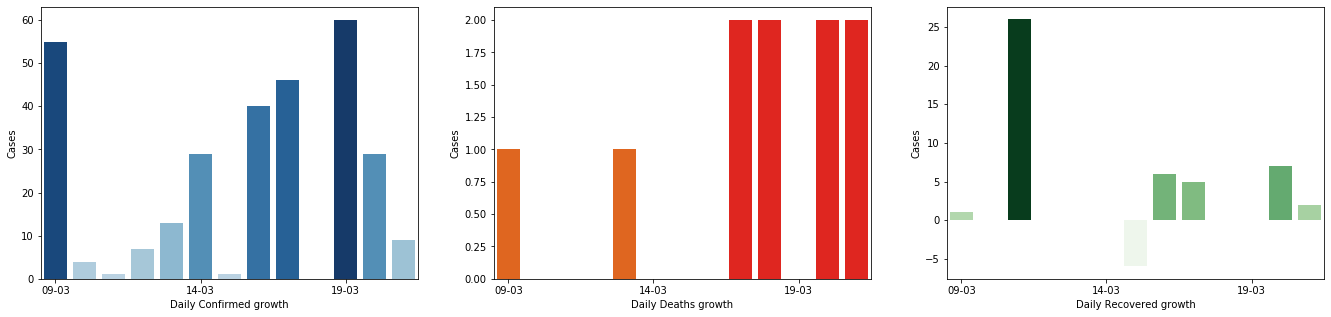

50 . South Africa
Confirmed: 240 
Active: 240 
Recovered: 0 
Deaths: 0


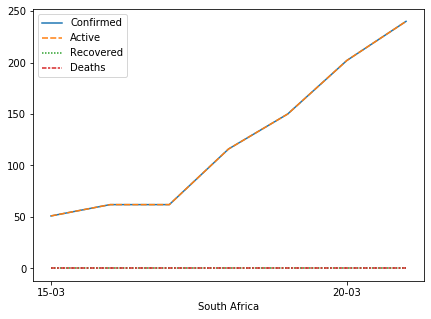


Daily growth for each types of cases



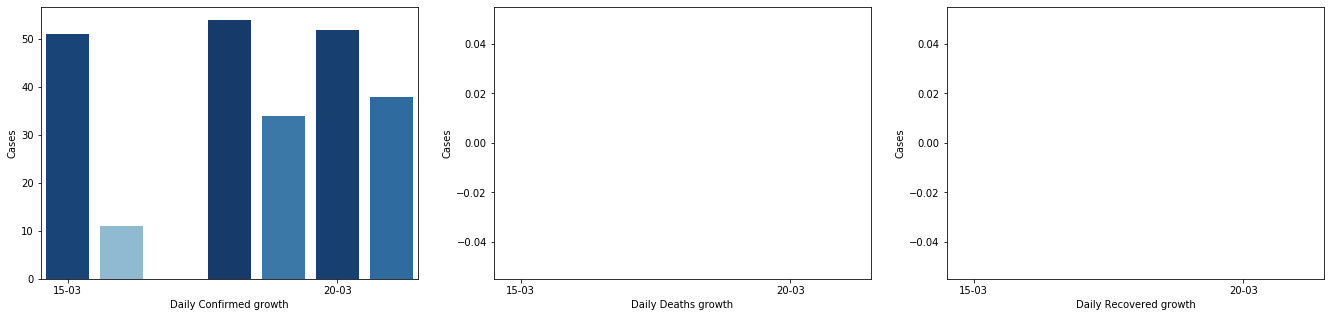

In [9]:
for index, country in enumerate(top_50.index):
    print(index+1,'.', country)
    print('Confirmed:', top_50.Confirmed[country],'\n'\
          'Active:', top_50.Active[country],'\n'\
          'Recovered:', top_50.Recovered[country],'\n'\
          'Deaths:', top_50.Deaths[country]
         )
    df, date_range = prepare_data(covid_19_df, country, 50)
    df = add_data(df)
    show_increment(df, country, date_range)